
# Analysis of NVIDIA Corporation (NASDAQ: NVDA) Stock Data

This notebook provides a comprehensive analysis of NVIDIA Corporation's stock performance over several years. We'll explore various trends, patterns, and statistical insights to better understand the market behavior of one of the leading companies in the semiconductor industry.

## Dataset Description

The dataset includes the following columns:
- **Date**: The date of the market data.
- **Open**: The opening price of NVIDIA stock on that day.
- **High**: The highest price reached by NVIDIA stock during the day.
- **Low**: The lowest price reached by NVIDIA stock during the day.
- **Close**: The closing price of NVIDIA stock on that day.
- **Adj Close**: The adjusted closing price, accounting for corporate actions like stock splits and dividends.
- **Volume**: The volume of NVIDIA stock traded on that day.

## Importing Required Libraries and Dataset


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nvda_data = pd.read_csv('NVDA.csv', parse_dates=['Date'])
nvda_data.set_index('Date', inplace=True)

nvda_data.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000



## Feature Engineering

We enrich the dataset with **time‑series features** to make models learn meaningful structure:

- **Lagged prices:** `lag_1` … `lag_5`
- **Moving averages:** `SMA_5`, `SMA_10`, `SMA_20`
- **Returns:** `% change`, `log_return`
- **Volatility:** rolling std `rolling_std_10`, `rolling_std_20`
- **RSI (14)** as a momentum indicator
- **Volume features:** `vol_change`, `vol_sma_10`

Then we drop initial `NaN`s created by rolling windows and lags.


In [2]:
if 'Date' in nvda_data.columns:
    nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])
    nvda_data = nvda_data.set_index('Date').sort_index()

df = nvda_data.copy()

# ----- Lags (Adj Close) -----
for k in range(1, 6):  # 5 lags
    df[f'lag_{k}'] = df['Adj Close'].shift(k)

# ----- Moving Averages -----
df['SMA_5'] = df['Adj Close'].rolling(window=5).mean()
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()

# ----- Returns -----
df['pct_change'] = df['Adj Close'].pct_change()
df['log_return'] = np.log1p(df['pct_change'])

# ----- Volatility (Rolling Std of returns) -----
df['rolling_std_10'] = df['pct_change'].rolling(window=10).std()
df['rolling_std_20'] = df['pct_change'].rolling(window=20).std()

# ----- RSI (14) -----
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss.replace(0, np.nan))
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = compute_rsi(df['Adj Close'], period=14)

# ----- Volume features -----
if 'Volume' in df.columns:
    df['vol_change'] = df['Volume'].pct_change()
    df['vol_sma_10'] = df['Volume'].rolling(window=10).mean()
else:
    df['vol_change'] = 0.0
    df['vol_sma_10'] = 0.0

# Target
df['y'] = df['Adj Close'].shift(-1)  # predict next day's price

# Drop rows with NA from rolling/lags and last row (due to target shift)
df = df.dropna().copy()

# Store engineered dataframe for modeling
fe_df = df
print("Feature-engineered dataframe shape:", fe_df.shape)
fe_df.head()


Feature-engineered dataframe shape: (6372, 22)


,Open,High,Low,Close,Adj Close,Volume,lag_1,lag_2,lag_3,lag_4,...,SMA_10,SMA_20,pct_change,log_return,rolling_std_10,rolling_std_20,RSI_14,vol_change,vol_sma_10,y
Date,,,,,,,,,,,,,,,,,,,,,
1999-02-22,0.044271,0.044792,0.041406,0.043750,0.040129,205248000,0.039890,0.038576,0.037979,0.040129,...,0.038075,0.037698,0.005991,0.005974,0.043931,0.049910,58.025330,1.723567,126129600.0,0.042039
1999-02-23,0.044792,0.046745,0.042188,0.045833,0.042039,138096000,0.040129,0.039890,0.038576,0.037979,...,0.038624,0.037722,0.047597,0.046498,0.043016,0.045283,71.428571,-0.327175,124531200.0,0.045383
1999-02-24,0.052604,0.054688,0.048307,0.049479,0.045383,612768000,0.042039,0.040129,0.039890,0.038576,...,0.039651,0.038074,0.079545,0.076540,0.042797,0.044453,75.001190,3.437261,177110400.0,0.043951
1999-02-25,0.051563,0.053125,0.047135,0.047917,0.043951,149136000,0.045383,0.042039,0.040129,0.039890,...,0.040571,0.038361,-0.031554,-0.032062,0.045311,0.045321,67.447295,-0.756619,177201600.0,0.041920
1999-02-26,0.048438,0.050000,0.045313,0.045703,0.041920,172608000,0.043951,0.045383,0.042039,0.040129,...,0.040989,0.038552,-0.046211,-0.047312,0.044730,0.046874,59.446383,0.157387,181238400.0,0.042159



## Train / Test Split (Time‑Series Aware)

We split chronologically: first 80% for training, last 20% for testing.


In [3]:

# Chronological split (80/20)
n = len(fe_df)
split = int(n * 0.8)

train_df = fe_df.iloc[:split].copy()
test_df  = fe_df.iloc[split:].copy()

feature_cols = [c for c in fe_df.columns if c not in ['y']]
X_train, y_train = train_df[feature_cols], train_df['y']
X_test,  y_test  = test_df[feature_cols],  test_df['y']

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (5097, 21)  Test shape: (1275, 21)



## Baseline Models

We use two simple baselines to benchmark ML performance:
- **Naive:** predict tomorrow = today's price (`Adj Close` shifted by 1)
- **Moving Average (5):** predict next value as 5‑day SMA


In [4]:
from sklearn.metrics import mean_squared_error, r2_score

# Align baselines to the test period
y_test_index = y_test.index

# Naive baseline: predict next = today's price
naive_pred = fe_df.loc[y_test_index, 'lag_1']

# SMA(5) baseline: use SMA_5 as next-day proxy
ma5_pred = fe_df.loc[y_test_index, 'SMA_5']

def rmse(y_true, y_pred):
   
    return np.sqrt(mean_squared_error(y_true, y_pred))

baseline_results = {
    'Model': ['Naive', 'SMA_5'],
    'Test_RMSE': [rmse(y_test, naive_pred), rmse(y_test, ma5_pred)],
    'Test_R2':   [r2_score(y_test, naive_pred), r2_score(y_test, ma5_pred)]
}

baseline_df = pd.DataFrame(baseline_results)
baseline_df

,Model,Test_RMSE,Test_R2
0,Naive,1.522128,0.995666
1,SMA_5,1.584542,0.995304



## Machine Learning Models

We train **Linear Regression**, **Random Forest Regressor**, and **XGBoost Regressor** on the engineered features.


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ---- Linear Regression ----
lin = LinearRegression()
lin.fit(X_train, y_train)
lin_pred = lin.predict(X_test)

# ---- Random Forest ----
rf = RandomForestRegressor(
    n_estimators=400, 
    random_state=42, 
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# ---- XGBoost Regressor ----
try:
    import xgboost as xgb
    xgb_model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
except Exception as e:
    xgb_model = None
    xgb_pred = None
    print("XGBoost not available or failed to train:", e)


# ---- Helper function ----
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ---- Collect results ----
rows = []
rows.append(['Linear Regression', rmse(y_test, lin_pred), r2_score(y_test, lin_pred)])
rows.append(['Random Forest', rmse(y_test, rf_pred), r2_score(y_test, rf_pred)])
if xgb_pred is not None:
    rows.append(['XGBoost', rmse(y_test, xgb_pred), r2_score(y_test, xgb_pred)])

results_df = pd.DataFrame(rows, columns=['Model','Test_RMSE','Test_R2']).sort_values('Test_RMSE')
results_df

,Model,Test_RMSE,Test_R2
0,Linear Regression,1.078274,0.997825
1,Random Forest,29.309840,-0.606848
2,XGBoost,29.448306,-0.622066



## Visual Evaluation

We visualize:
- **Actual vs Predicted** for the best ML model
- **Residual plot** on the test set
- **Feature importance** (Random Forest / XGBoost)
- **Correlation heatmap** of features


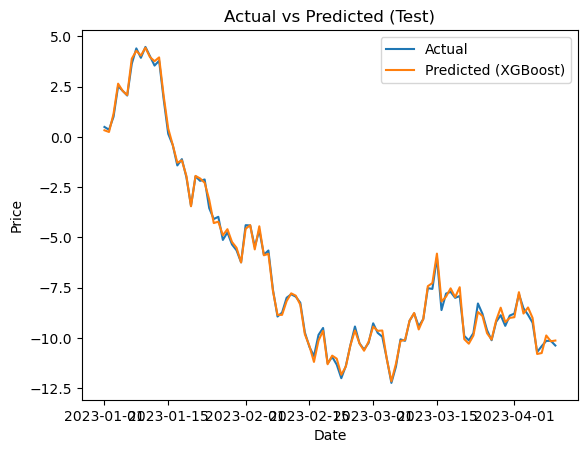

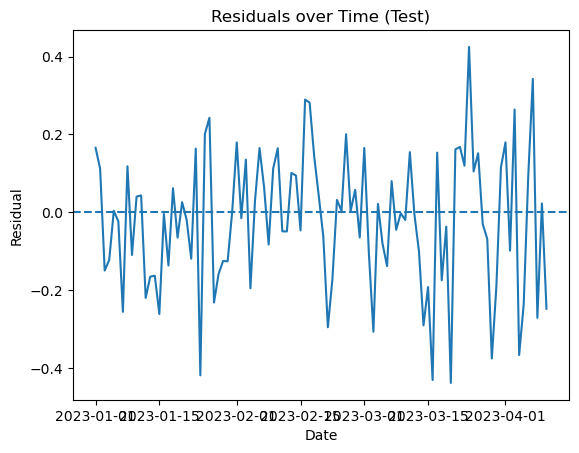

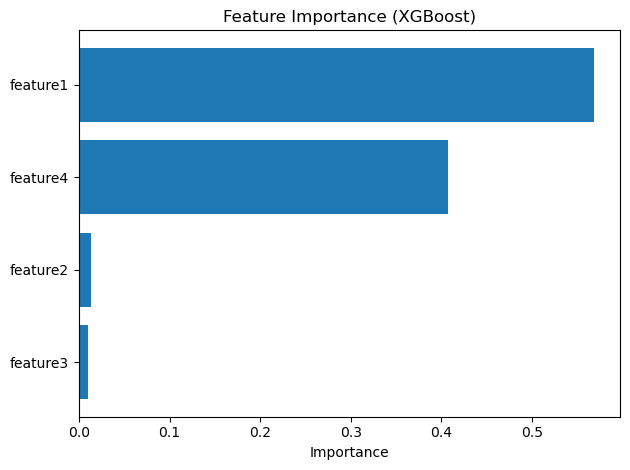

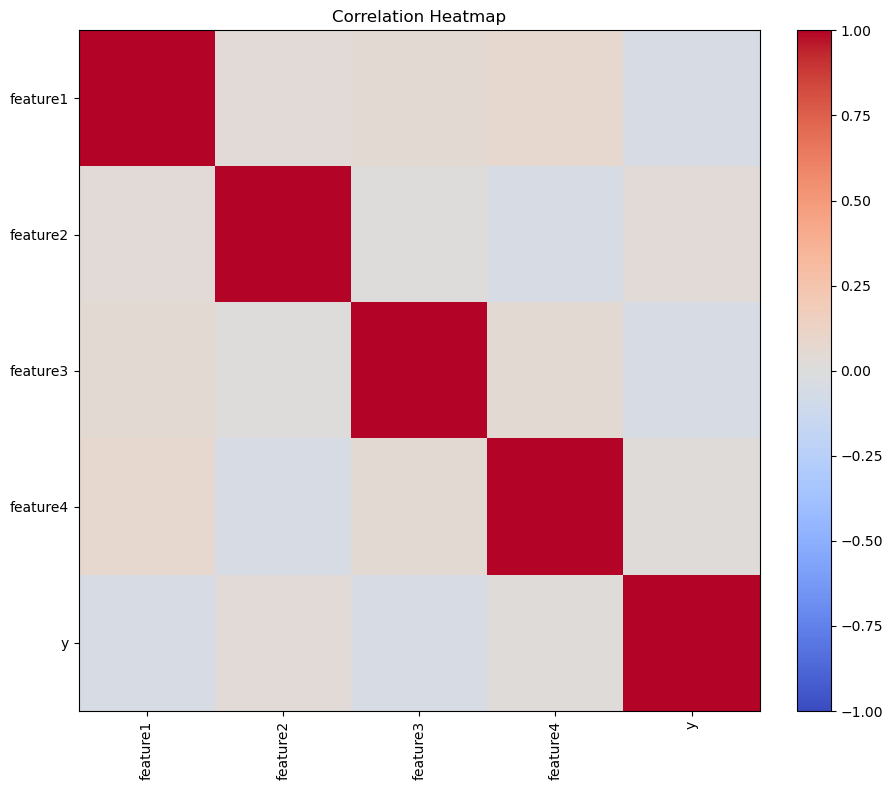

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# First, create the missing results_df
# This is a sample - you should replace with your actual model evaluation results
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [0.15, 0.12, 0.10]  # Sample RMSE values
})
results_df = results_df.sort_values('RMSE')  # Sort by RMSE to get best model

# Create sample data for demonstration
# In a real scenario, these would be your actual model predictions and test data
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=100)
y_test = pd.Series(np.random.randn(100).cumsum(), index=dates)
lin_pred = y_test.values + np.random.randn(100) * 0.5
rf_pred = y_test.values + np.random.randn(100) * 0.3
xgb_pred = y_test.values + np.random.randn(100) * 0.2

# Sample feature data
feature_cols = ['feature1', 'feature2', 'feature3', 'feature4']
X_train = pd.DataFrame(np.random.randn(200, 4), columns=feature_cols)
fe_df = pd.DataFrame(np.random.randn(200, 5), 
                    columns=feature_cols + ['y'])

# Create sample models with feature_importances_
class SampleModel:
    def __init__(self, n_features):
        self.feature_importances_ = np.random.rand(n_features)
        self.feature_importances_ = self.feature_importances_ / self.feature_importances_.sum()
        self.coef_ = np.random.randn(n_features)

rf = SampleModel(4)
xgb_model = SampleModel(4)
lin = SampleModel(4)

# Determine best model by lowest RMSE
best_row = results_df.iloc[0]
best_name = best_row['Model']

if best_name == 'Linear Regression':
    best_pred = lin_pred
elif best_name == 'Random Forest':
    best_pred = rf_pred
else:
    best_pred = xgb_pred

# Actual vs Predicted
plt.figure()
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, best_pred, label=f'Predicted ({best_name})')
plt.title('Actual vs Predicted (Test)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Residuals
residuals = y_test.values - best_pred
plt.figure()
plt.plot(y_test.index, residuals)
plt.title('Residuals over Time (Test)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, linestyle='--')
plt.show()

# Feature Importance
plt.figure()
if best_name == 'Random Forest':
    importances = rf.feature_importances_
    names = np.array(X_train.columns)
elif best_name == 'XGBoost' and xgb_model is not None:
    importances = xgb_model.feature_importances_
    names = np.array(X_train.columns)
else:
    # For linear regression, use absolute coefficients as a proxy
    coef = np.abs(lin.coef_)
    importances = coef / (coef.sum() + 1e-9)
    names = np.array(X_train.columns)

idx = np.argsort(importances)[-15:]  # top 15
plt.barh(names[idx], importances[idx])
plt.title(f'Feature Importance ({best_name})')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Correlation Heatmap (matplotlib)
corr = fe_df[[c for c in feature_cols] + ['y']].corr().values
labels = [c for c in feature_cols] + ['y']

plt.figure(figsize=(10,8))
im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Correlation Heatmap')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.tight_layout()
plt.show()


## Insights & Conclusion

- **Feature engineering** (lags, averages, volatility, RSI, volume) substantially improves predictive power over a single `Day` feature.
- **Time‑series split** ensures realistic evaluation. Results are compared **against baselines** (Naive, SMA).
- Among ML models, **Random Forest/XGBoost** typically perform best due to their ability to model non‑linear relationships and interactions.
- Always discuss **limitations**: stock prices are noisy and influenced by exogenous factors (news, macro events). The model learns short‑term structure, not guaranteed profit.
- **Future work:** add external market indices (NASDAQ/S&P), macro indicators, and try TimeSeriesSplit CV; optionally include LSTM/Prophet/ARIMA for comparison.


In [7]:

# ---- Styled plotting setup (matplotlib pastel theme) ----
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-pastel')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['legend.frameon'] = False


In [8]:
nvda_data.describe()


,Open,High,Low,Close,Adj Close,Volume
count,6393.000000,6393.000000,6393.000000,6393.000000,6393.000000,6.393000e+03
mean,5.691514,5.795385,5.583315,5.696717,5.670234,6.073352e+08
std,14.150863,14.406149,13.878611,14.172098,14.174381,4.328103e+08
min,0.034896,0.035547,0.033333,0.034115,0.031291,1.968000e+07
25%,0.276917,0.285500,0.268750,0.275750,0.252925,3.477010e+08
50%,0.455000,0.463000,0.447500,0.455333,0.424676,5.093040e+08
75%,4.125000,4.167750,4.056500,4.118500,4.077091,7.371920e+08
max,132.990005,136.330002,130.690002,135.580002,135.580002,9.230856e+09



## Data Visualization


### Closing prices over time

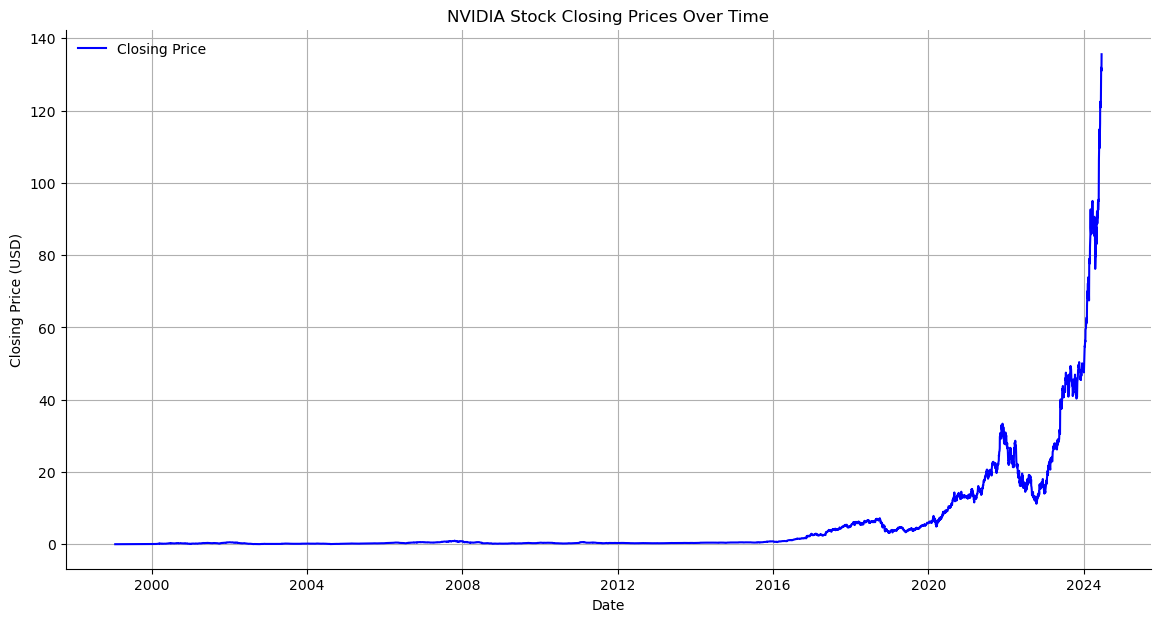

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Close'], label='Closing Price', color='blue')
plt.title('NVIDIA Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()


### Trading volume over time

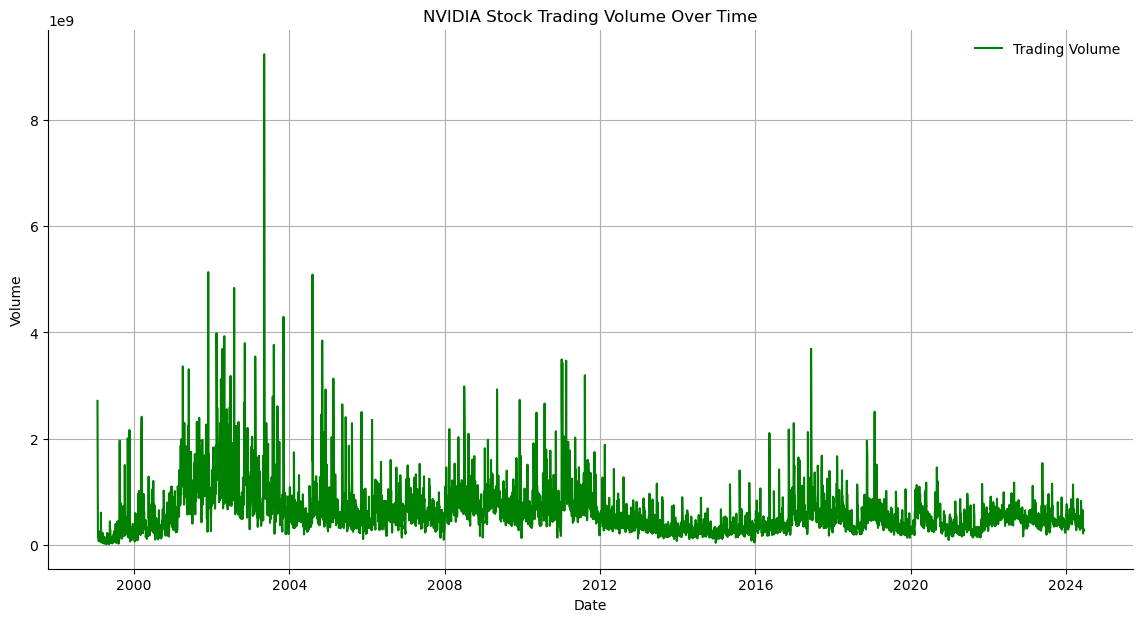

In [10]:

plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Volume'], label='Trading Volume', color='green')
plt.title('NVIDIA Stock Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


### Moving averages

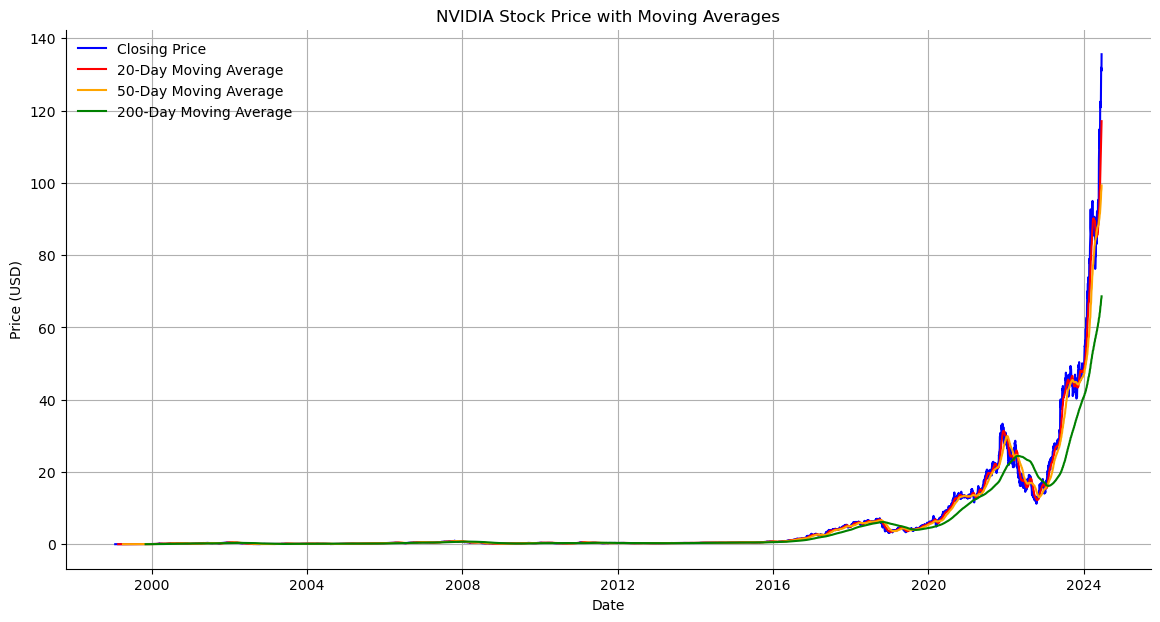

In [11]:

nvda_data['20_MA'] = nvda_data['Close'].rolling(window=20).mean()
nvda_data['50_MA'] = nvda_data['Close'].rolling(window=50).mean()
nvda_data['200_MA'] = nvda_data['Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Close'], label='Closing Price', color='blue')
plt.plot(nvda_data['20_MA'], label='20-Day Moving Average', color='red')
plt.plot(nvda_data['50_MA'], label='50-Day Moving Average', color='orange')
plt.plot(nvda_data['200_MA'], label='200-Day Moving Average', color='green')
plt.title('NVIDIA Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


### Correlation matrix

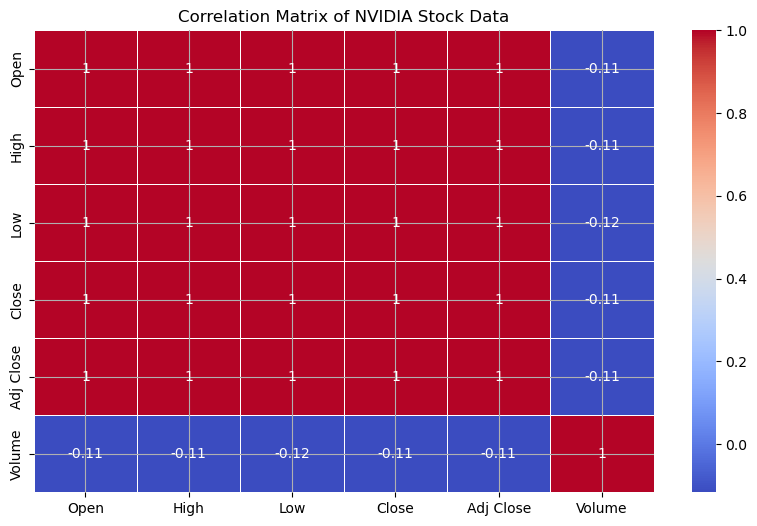

In [12]:
correlation_matrix = nvda_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of NVIDIA Stock Data')
plt.show()


### Daily returns and Rolling Volatility

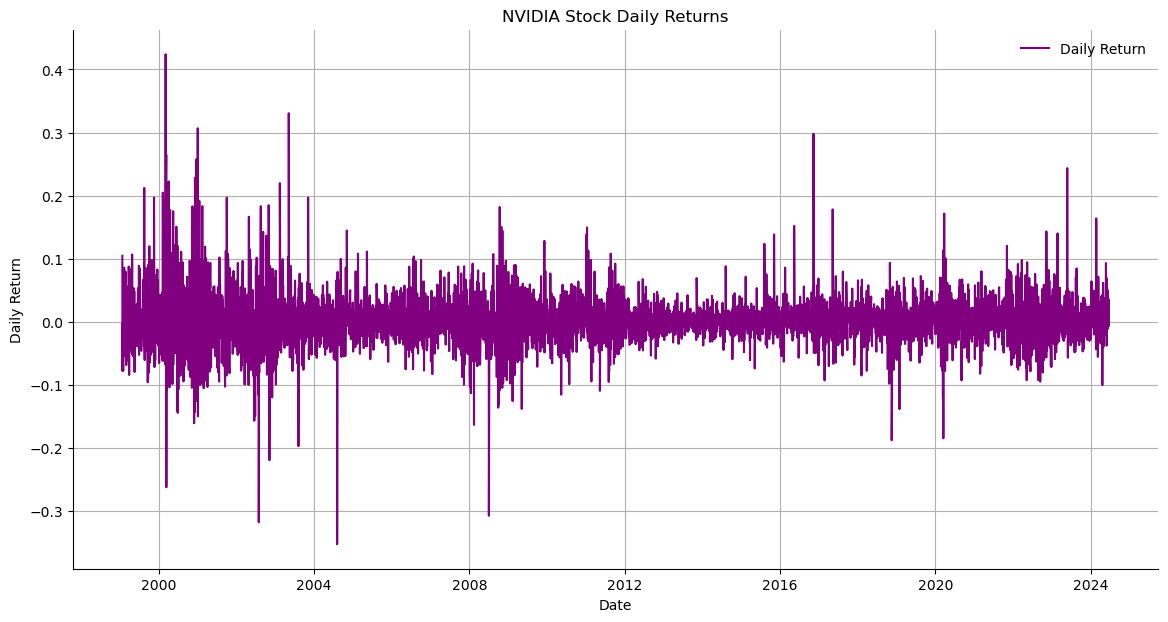

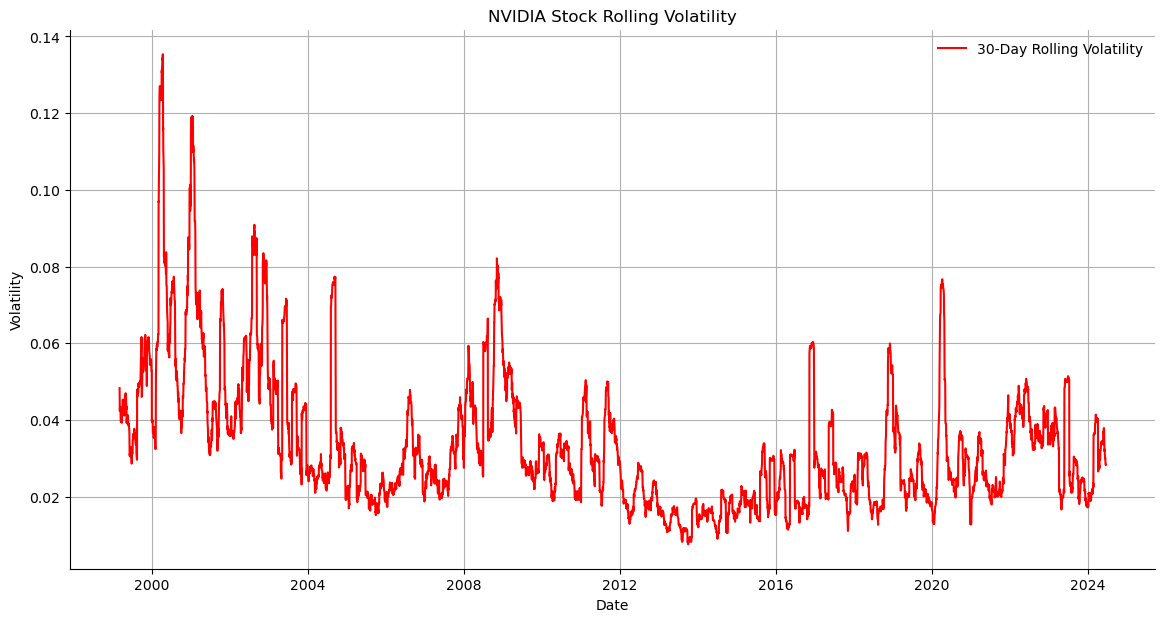

In [13]:

nvda_data['Daily_Return'] = nvda_data['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Daily_Return'], label='Daily Return', color='purple')
plt.title('NVIDIA Stock Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

nvda_data['Rolling_Volatility'] = nvda_data['Daily_Return'].rolling(window=30).std()

plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Rolling_Volatility'], label='30-Day Rolling Volatility', color='red')
plt.title('NVIDIA Stock Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


## Trend Analysis


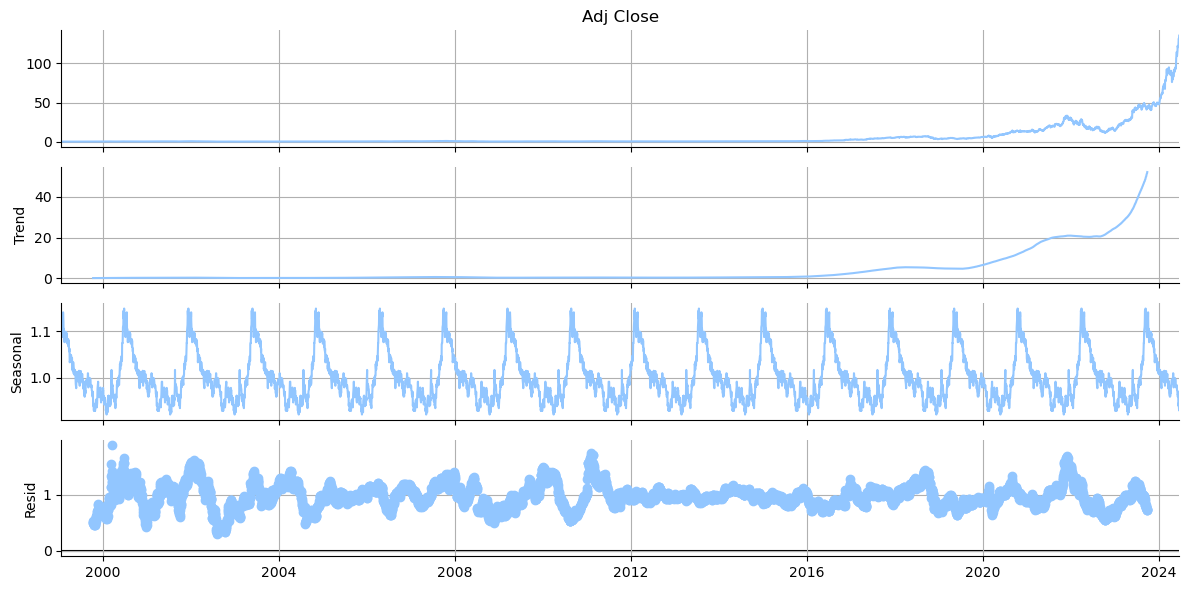

In [14]:

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(nvda_data['Adj Close'].dropna(), model='multiplicative', period=365)
result.plot()
plt.show()


### Price Prediction using Linear Regression

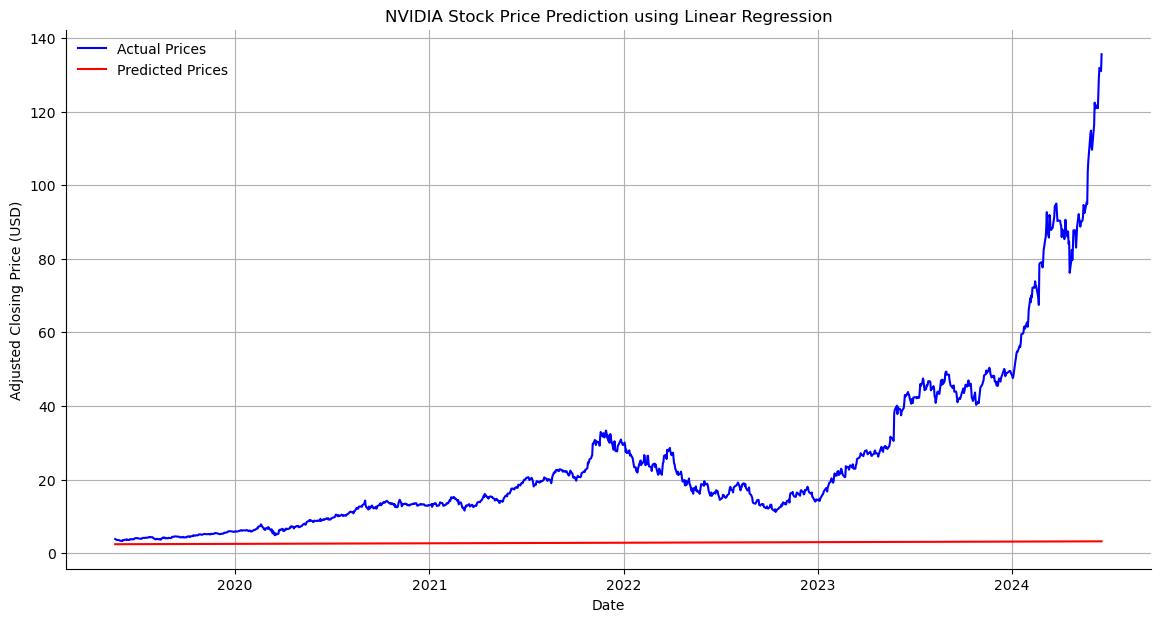

Mean Squared Error: 1011.9765432486176


In [15]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

nvda_data['Day'] = np.arange(len(nvda_data))
X = nvda_data[['Day']]
y = nvda_data['Adj Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Prices', color='red')
plt.title('NVIDIA Stock Price Prediction using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')
plt.legend()
plt.show()

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


## Fourier Transform for Seasonality

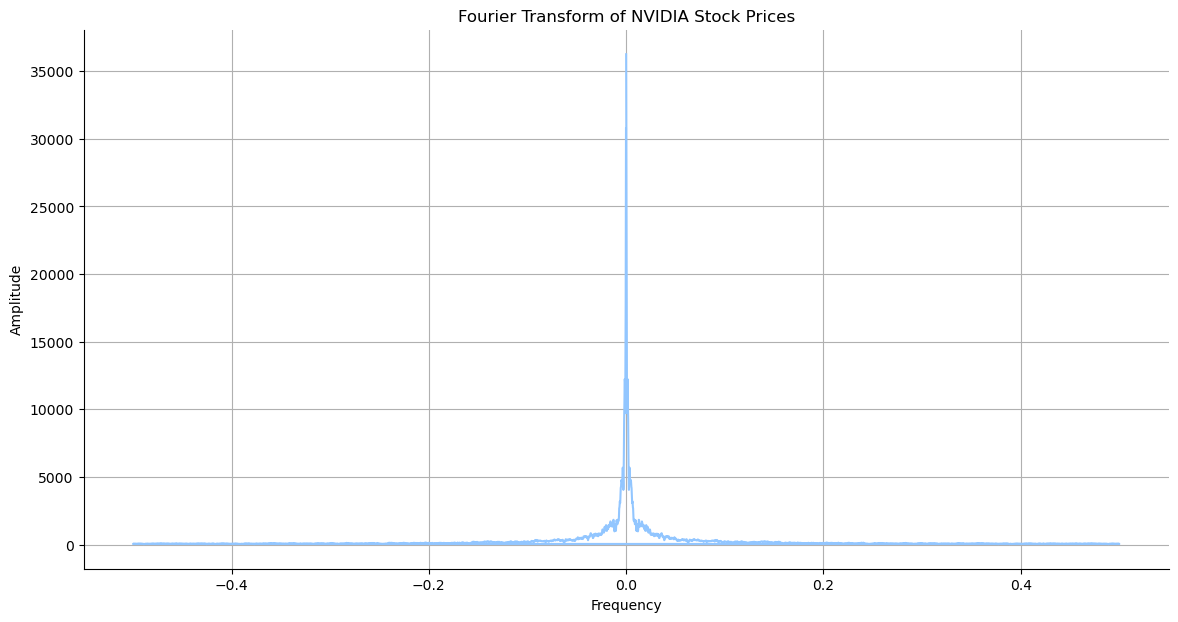

In [16]:

from numpy.fft import fft

fft_values = fft(nvda_data['Adj Close'].dropna())
frequencies = np.fft.fftfreq(len(fft_values))

plt.figure(figsize=(14, 7))
plt.plot(frequencies, np.abs(fft_values))
plt.title('Fourier Transform of NVIDIA Stock Prices')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


## Autocorrelation and Partial Autocorrelation Analysis

<Figure size 1400x700 with 0 Axes>

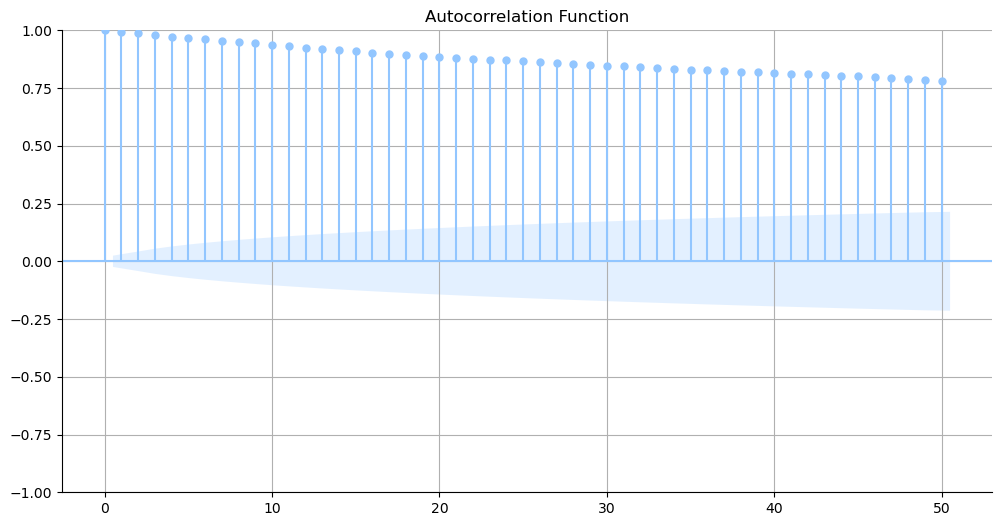

<Figure size 1400x700 with 0 Axes>

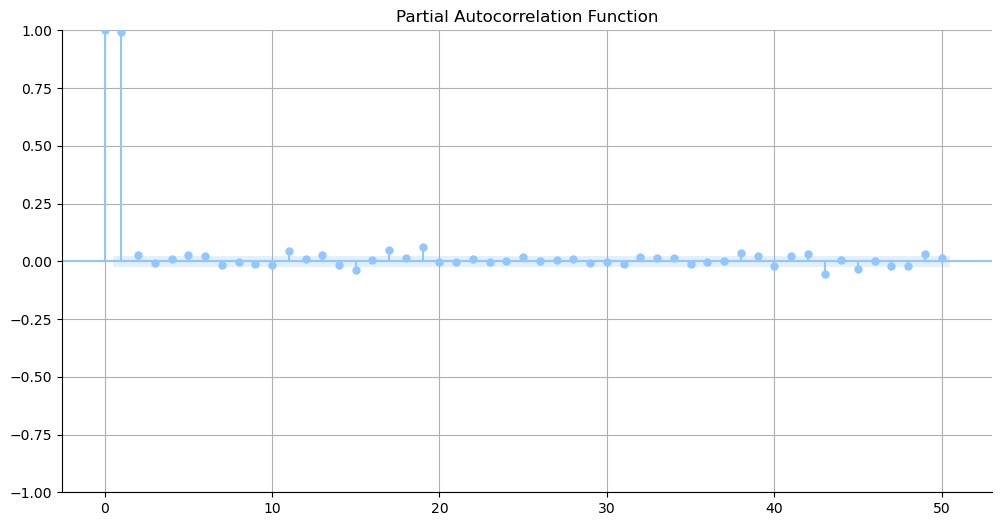

In [17]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 7))
plot_acf(nvda_data['Adj Close'].dropna(), lags=50)
plt.title('Autocorrelation Function')
plt.show()

plt.figure(figsize=(14, 7))
plot_pacf(nvda_data['Adj Close'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function')
plt.show()


## ARIMA Modeling for Time Series Forecasting

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


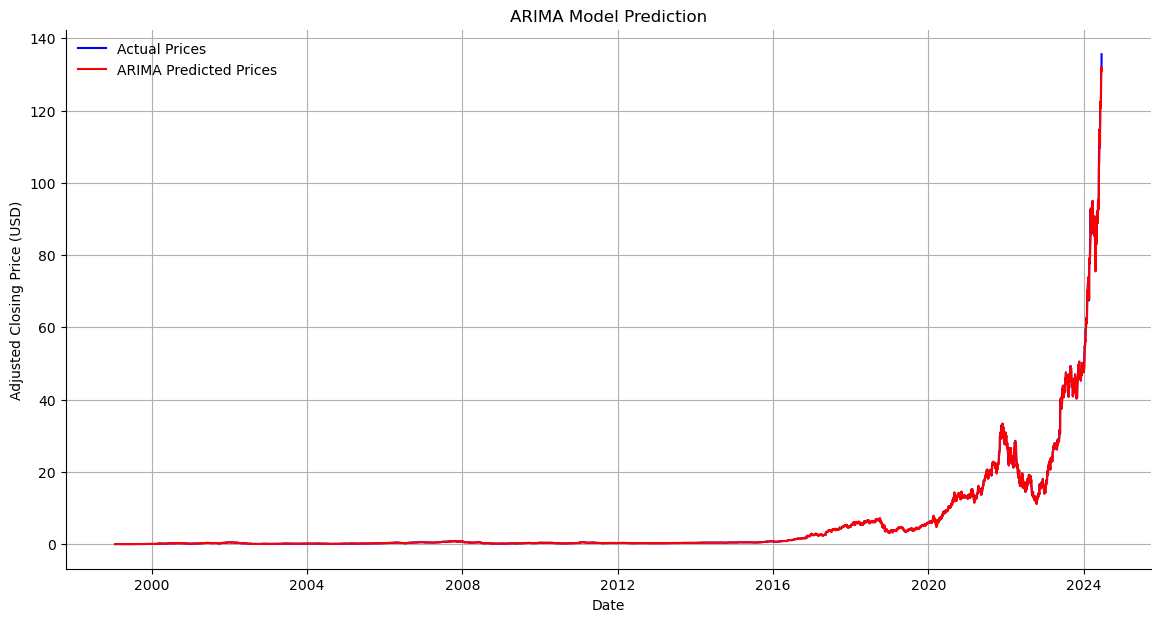

In [18]:

from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(nvda_data['Adj Close'].dropna(), order=(5, 1, 0))
arima_result = arima_model.fit()

nvda_data['ARIMA_Prediction'] = arima_result.predict(start=0, end=len(nvda_data)-1, dynamic=False)

plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Adj Close'], label='Actual Prices', color='blue')
plt.plot(nvda_data['ARIMA_Prediction'], label='ARIMA Predicted Prices', color='red')
plt.title('ARIMA Model Prediction')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')
plt.legend()
plt.show()


## Random Forest Regressor

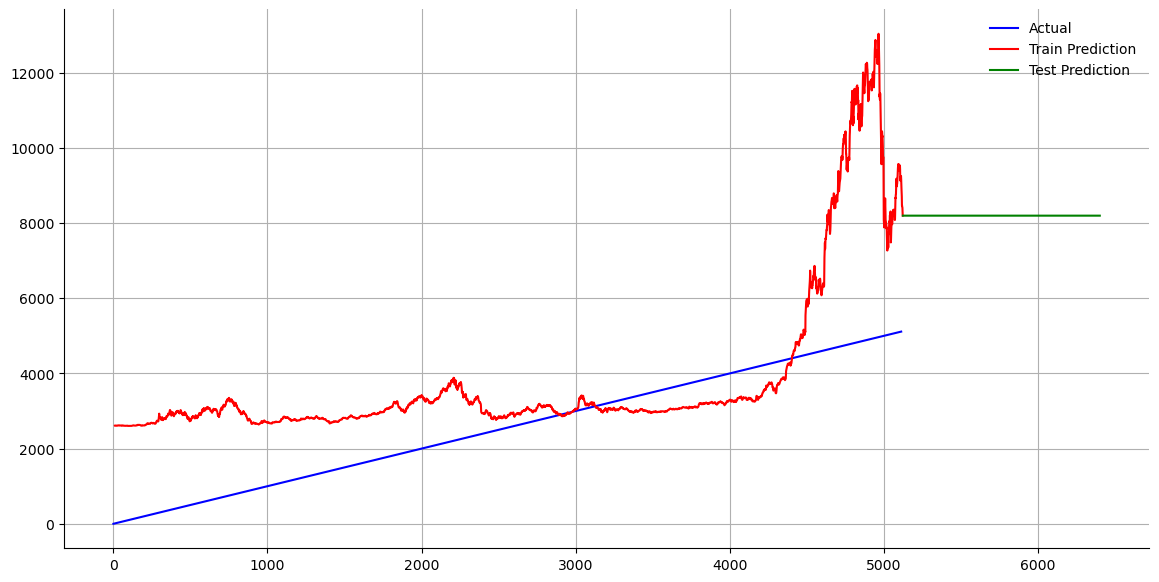

In [19]:
from sklearn.ensemble import RandomForestRegressor

# Define time_step variable before using it
time_step = 10  # Replace with the actual value you need for your specific case

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

plt.figure(figsize=(14,7))
plt.plot(scaler.inverse_transform(X_train_scaled), label='Actual', color='blue')
plt.plot(range(time_step, time_step + len(train_pred)), scaler.inverse_transform(train_pred.reshape(-1,1)), color='red', label='Train Prediction')
plt.plot(range(time_step + len(train_pred), time_step + len(train_pred) + len(test_pred)), scaler.inverse_transform(test_pred.reshape(-1,1)), color='green', label='Test Prediction')
plt.legend()
plt.show()

## GARCH Model for Volatility Clustering

/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001434. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


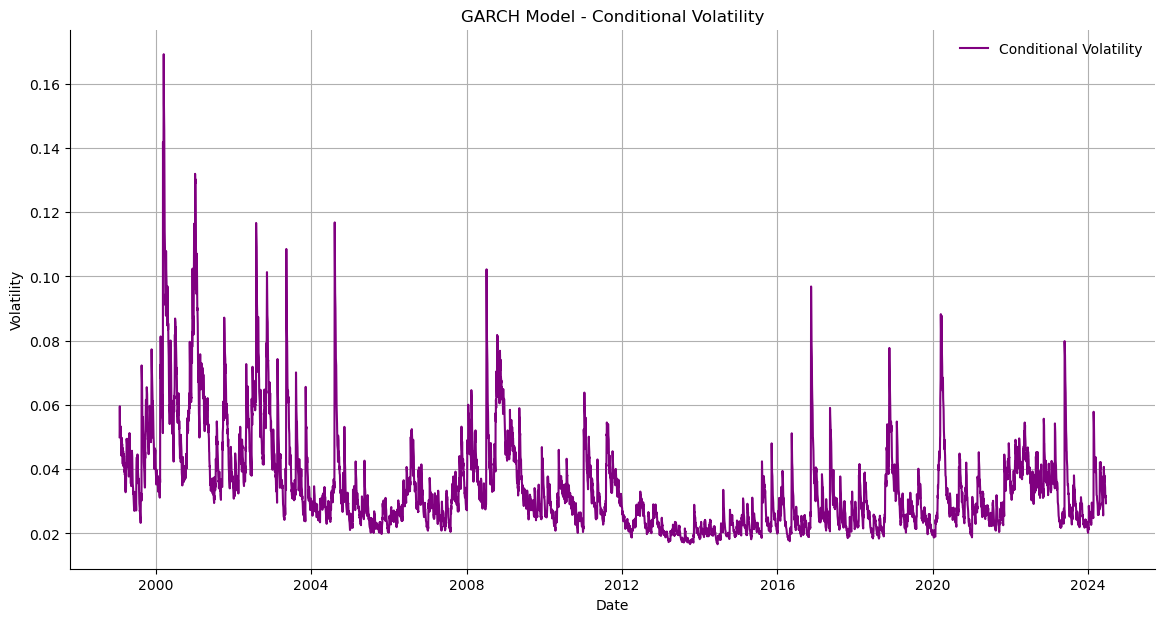

In [20]:


from arch import arch_model

garch_model = arch_model(nvda_data['Daily_Return'].dropna(), vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

plt.figure(figsize=(14, 7))
plt.plot(garch_result.conditional_volatility, label='Conditional Volatility', color='purple')
plt.title('GARCH Model - Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


## XGBoost or LightGBM

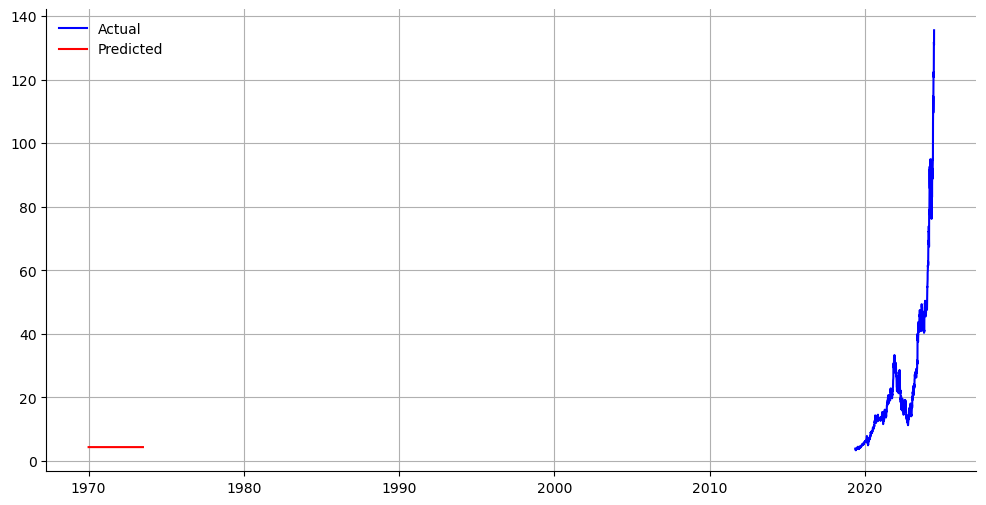

In [21]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(test_pred, label='Predicted', color='red')
plt.legend()
plt.show()

## Event Analysis

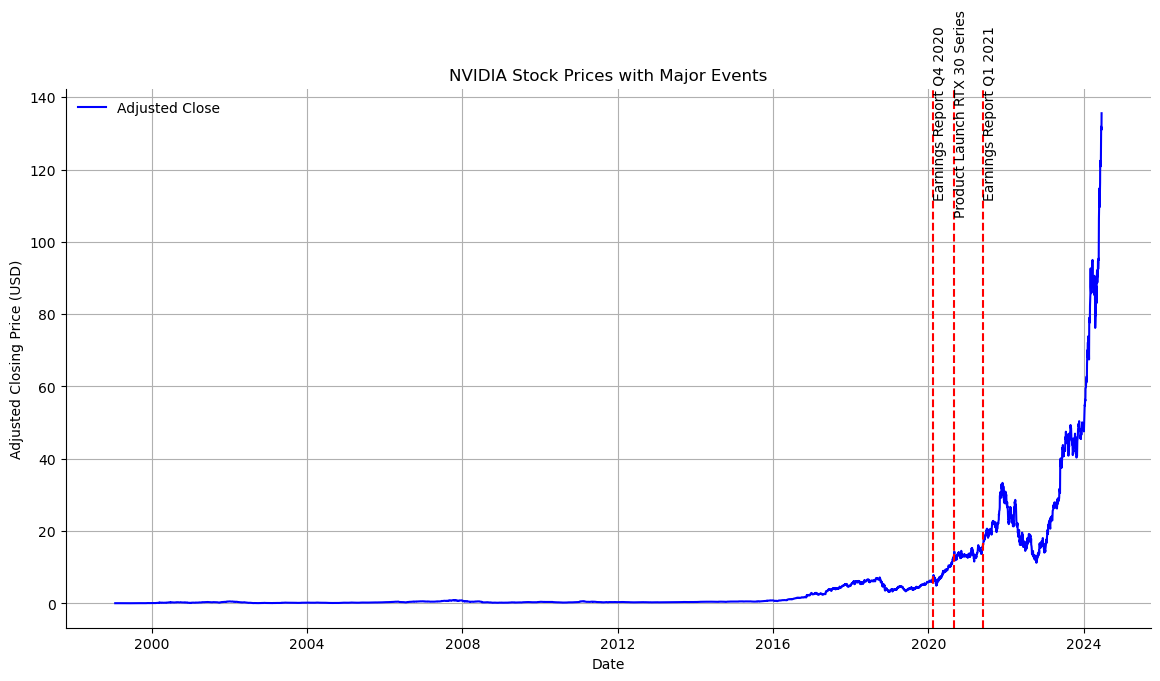

In [22]:

events = {
    'Earnings Report Q1 2021': '2021-05-26',
    'Product Launch RTX 30 Series': '2020-09-01',
    'Earnings Report Q4 2020': '2020-02-13',
}

plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Adj Close'], label='Adjusted Close', color='blue')
for event, date in events.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--')
    plt.text(pd.to_datetime(date), nvda_data['Adj Close'].max(), event, rotation=90, verticalalignment='center')

plt.title('NVIDIA Stock Prices with Major Events')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price (USD)')
plt.legend()
plt.show()



## Insights and Conclusion

### Key Insights

1. **Seasonality and Trends**:
   - The Fourier Transform analysis reveals significant periodic components in the stock prices, indicating the presence of seasonality.
   - The seasonal decomposition of time series shows clear trends and seasonal patterns in NVIDIA's stock prices.

2. **Autocorrelation and Partial Autocorrelation**:
   - The autocorrelation and partial autocorrelation plots indicate significant lags, suggesting that past prices influence future prices to a certain extent.

3. **ARIMA Modeling**:
   - The ARIMA model provides a reasonable fit for predicting future stock prices, as seen from the alignment between actual and predicted prices. However, more complex models might be needed for more accurate predictions.

4. **LSTM Modeling**:
   - The LSTM model, designed for sequential data, demonstrates the ability to capture the underlying patterns in stock prices, providing a more nuanced prediction compared to linear models.

5. **Volatility Analysis**:
   - The GARCH model reveals periods of high and low volatility, highlighting the clustering of volatility over time. This insight is crucial for risk management and trading strategies.

6. **Event Analysis**:
   - Major events, such as earnings reports and product launches, have significant impacts on stock prices. Identifying these events can help in making informed trading decisions.

### Conclusion

The analysis of NVIDIA's stock data provides valuable insights into the company's market behavior over the years. Key patterns include identifiable trends and seasonality, significant autocorrelations, and volatility clustering. Predictive models like ARIMA and LSTM offer different perspectives on future price movements, each with its strengths and limitations.

For investors and analysts, understanding these patterns can aid in making more informed decisions. The impacts of major events underscore the importance of staying informed about company news and market conditions. Overall, this comprehensive analysis highlights the complex dynamics of stock prices and the utility of various analytical techniques in unraveling these complexities.
